In [3]:
from models import resnet, densenet
import unet

import torch
import torch.nn as nn
from torch.autograd import Variable

import os, sys, math
import numpy as np

from sklearn.metrics import precision_recall_fscore_support as score

model = unet.unet(is_deconv=False)
model.load_state_dict(torch.load('ckpts/train11_ckpt'))
model = model.cuda()

l1_filter = nn.Conv3d(1, 1, 32, stride=1, padding=0).cuda()
l1_filter.weight.data.fill_(1)

root = '/deep/group/shubhang/luna16/lungs/'
gt_root = '/deep/group/shubhang/luna16/gt/'

def forward(ct_slice):
    return model.forward(Variable(torch.from_numpy(ct_slice.astype(float)).cuda().float())).view(1, 1, -1, 512, 512)

ids = os.listdir(root)
amt = len(ids)
scores = []
for num, cid in enumerate(ids):
    sys.stdout.write('\r%d/%d' % (num+1, amt))
            
    curr = np.expand_dims(np.load(root + cid), axis=1)
    gt = np.load(gt_root + cid).reshape(-1)

    ct = []
    sz = 40
    for i in range(0, curr.shape[0], sz):
        ct_slice = forward(curr[i:i+sz]).cpu().data.numpy()
        ct.append((ct_slice > 0.5).astype(int))

    seg = np.concatenate(ct, axis=2).reshape(-1)
    prec, rec, f1, _ = score(gt, seg, average='binary')
    scores.append(np.array([prec, rec, f1]))
    
    if num == 60:
        break

print()
print(np.array(scores).shape)

61/601
(61, 3)


In [6]:
np.mean(np.array(scores), axis=0)

array([ 0.00121184,  0.60733371,  0.00240991])

In [1]:
from utils import *

import os
from random import shuffle

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
luna_root = '/deep/group/shubhang/luna16/'
img, target = np.load(luna_root + 'lungs/178680586845223339579041794709.npy'), np.load(luna_root + 'gt/178680586845223339579041794709.npy')
print(img.shape, target.shape)

(332, 512, 512) (332, 512, 512)


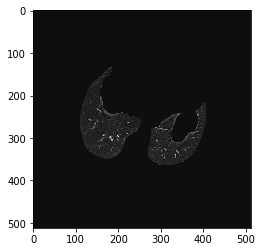

In [36]:
z_tumor = np.where(target==1)[0]

plt.imshow(img[z_tumor[40]], cmap=plt.cm.gray)

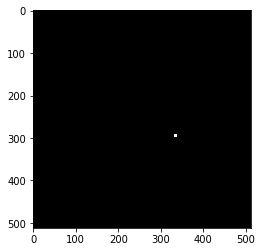

In [35]:
plt.imshow(target[z_tumor[40]], cmap=plt.cm.gray)

In [23]:
unet = unet_model()

/afs/cs.stanford.edu/u/shubhang/luna16/unet.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  conv1 = Dropout(0.2)(conv1)
/afs/cs.stanford.edu/u/shubhang/luna16/unet.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
/afs/cs.stanford.edu/u/shubhang/luna16/unet.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
  conv2 = Dropout(0.2)(conv2)
/afs/cs.stanford.edu/u/shubhang/luna16/unet.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
/afs/cs.stanford.edu/u/shubhang/luna16/unet.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
  conv3 = D

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 512, 512, 64) 640         input_12[0][0]                   
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 512, 512, 64) 0           conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 512, 512, 64) 36928       dropout_38[0][0]                 
__________________________________________________________________________________________________
max_poolin

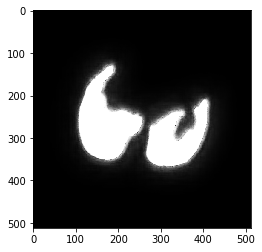

In [45]:
out = unet.predict(img[z_tumor[40]].reshape((1, 512, 512, 1)))
plt.imshow(np.squeeze(out), cmap=plt.cm.gray)

In [57]:
img, target = np.load(luna_root + 'lungs/178680586845223339579041794709.npy'), np.load(luna_root + 'gt/178680586845223339579041794709.npy')
z_tumor = np.where(target==1)[0]
img, target = np.expand_dims(img[np.unique(z_tumor)], 3), np.expand_dims(target[np.unique(z_tumor)], 3)
print(img.shape, target.shape)

(8, 512, 512, 1) (8, 512, 512, 1)


In [70]:
img_small = img.astype(np.float16)
print(img_small.dtype)

float16


In [ ]:
ids = os.listdir(luna_root + 'lungs/')
for cid in ids:
    if os.path.exists(luna_root + 'lungs_small/' + cid):
        continue
    img, target = np.load(luna_root + 'lungs/' + cid), np.load(luna_root + 'gt/' + cid)
    z_tumor = np.where(target==1)[0]
    img, target = np.expand_dims(img[np.unique(z_tumor)], 3), np.expand_dims(target[np.unique(z_tumor)], 3)
    img, target = np.rollaxis(img, 3, 1), np.rollaxis(target, 3, 1)
    #np.save(luna_root + 'lungs_small/' + cid, img.astype(float))
    #np.save(luna_root + 'gt_small/' + cid, img.astype(np.uint8))

    for i in range(img.shape[0]):
        name = cid.replace('.npy', '_' + str(i) + '.npy')
        np.save(luna_root + 'lungs_batch/' + name, img[i])
        np.save(luna_root + 'gt_batch/' + name, target[i])

In [33]:
ids = os.listdir(luna_root + 'lungs_batch/')
for cid in ids:
    img, target = np.load(luna_root + 'lungs_batch/' + cid), np.load(luna_root + 'gt_batch/' + cid)
    print(img.shape, target.shape)

(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)
(1, 512, 512) (1, 512, 512)


In [14]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
	return -dice_coef(y_true, y_pred)

'''
The UNET model is compiled in this function.
'''
def unet_model():
    inputs = Input((512, 512, 1))
    conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    
    model = Model(input=inputs, output=conv10)
    model.summary()
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [15]:
unet_model()

/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), act

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 512, 512, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 512, 512, 64) 0           conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 512, 512, 64) 36928       dropout_25[0][0]                 
__________________________________________________________________________________________________
max_poolin

/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="sigmoid")`
/afs/cs.stanford.edu/u/shubhang/.env/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [5]:
ids = os.listdir(luna_root + 'lungs_batch/')
len(ids)

9256

In [10]:
from random import shuffle
shuffle(ids)

for cid in ids[:100]:
    img, target = np.load(luna_root + 'lungs_batch/' + cid), np.load(luna_root + 'gt_batch/' + cid)
    np.save(luna_root + 'lungs_overfit/' + cid, img)
    np.save(luna_root + 'gt_overfit/' + cid, target)

In [1]:
from models import resnet, densenet

import torch
from torch.autograd import Variable

import numpy as np

dummy = np.zeros((6, 1, 64, 64, 64))
dummy = Variable(torch.from_numpy(dummy).float().cuda())

densenet121 = densenet.densenet121(sample_size=64, sample_duration=64, num_classes=1).cuda()
print(densenet121.forward(dummy))

res18 = resnet.resnet18(num_classes=1).cuda()
print(res18.forward(dummy))

Variable containing:
1.00000e-02 *
  2.3074
  2.3074
  2.3074
  2.3074
  2.3074
  2.3074
[torch.cuda.FloatTensor of size 6x1 (GPU 0)]

Variable containing:
 0.5066
 0.5066
 0.5066
 0.5066
 0.5066
 0.5066
[torch.cuda.FloatTensor of size 6x1 (GPU 0)]



In [2]:
res18

ResNet (
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool3d (size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddi

In [4]:
densenet121

DenseNet (
  (features): Sequential (
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU (inplace)
    (pool0): MaxPool3d (size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock (
      (denselayer1): _DenseLayer (
        (norm.1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (norm.2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU (inplace)
        (conv.2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer (
        (norm.1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv3d(96, 128, kernel_size=(1, 1, 1), stride=(1

In [2]:
import unet

model = unet.unet(is_deconv=False)
model.load

unet (
  (conv1): unetConv2 (
    (conv1): Sequential (
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU ()
    )
    (conv2): Sequential (
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU ()
    )
  )
  (maxpool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): unetConv2 (
    (conv1): Sequential (
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU ()
    )
    (conv2): Sequential (
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU ()
    )
  )
  (maxpool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): unetConv2 (
    (conv1): Sequential (
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1

In [8]:
test = ids[0].replace('.npy', '')
test

'194488534645348916700259325236'

In [9]:
import pandas as pd

df = pd.read_csv('/deep/group/shubhang/luna16/annotations.csv')

In [10]:
df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
